# Improving our model

Bertrand Thia (bt2513)

In this notebook, we are going to tune our previous model to improve it.

---

In [13]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight

# Loading the data

In [2]:
train_labels = pd.read_csv('./train.csv')

In [3]:
train_labels['label'].value_counts()

normal       350
bacterial    350
viral        350
covid         77
Name: label, dtype: int64

In [4]:
train_labels['label'].value_counts(normalize= True)

normal       0.310559
bacterial    0.310559
viral        0.310559
covid        0.068323
Name: label, dtype: float64

As we saw in the previous notebook, our dataset is imbalanced and the number of covid cases is very low (~6% of the data). To address this issue, we will try class weigthing and oversampling later.

# Data preprocessing

### Splitting into training set and validation set 

In [5]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

### Loading the standardized data

Let's load the standardized data that we processed in the previous notebook:

In [60]:
train_datagen = ImageDataGenerator(shear_range= 0.2,
                                  horizontal_flip= True,
                                  rotation_range= 20,
                                  zoom_range= 0.2)

val_datagen = ImageDataGenerator()

In [61]:
X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= './train2/',
                                            x_col = 'filename',
                                            y_col = 'label',
                                            target_size= (188, 234), 
                                            batch_size= 32, 
                                            color_mode= 'grayscale',
                                            seed= 0)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= './train2/',
                                        x_col = 'filename',
                                        y_col = 'label',
                                        target_size= (188, 234), 
                                        batch_size= 32, 
                                        color_mode= 'grayscale',
                                        seed= 0)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

We are going to complexify our model to see if it can learn more:

In [80]:
bas_model = Sequential()
bas_model.add(Conv2D(32, (3, 3), input_shape= (188, 234, 1), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Conv2D(64, (3, 3), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Conv2D(128, (3, 3), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Flatten())
bas_model.add(Dense(units= 256, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 
bas_model.add(Dense(units= 128, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 
bas_model.add(Dense(units= 4, activation= 'softmax'))

In [81]:
bas_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 186, 232, 32)      320       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 93, 116, 32)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 91, 114, 64)       18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 45, 57, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 43, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 21, 27, 128)       0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 72576)           

In [82]:
bas_model.compile(loss= 'categorical_crossentropy',
                 optimizer= Adam(), 
                 metrics = ['accuracy'])

* ### Training 

In [83]:
epochs= 50
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True, patience= 5)
#checkpoint = ModelCheckpoint("best_model.hdf5", monitor= 'val_acc', verbose= 1, save_best_only= True)

This time, we are going to use class weigthing to address the imbalance issue:

In [84]:
train_set2 = train_set.copy()
train_set2['label'] = train_set2['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3})
class_weight = compute_class_weight('balanced', [0, 1, 2, 3], train_set2['label'])
class_weight

array([0.80446429, 3.69262295, 0.80446429, 0.80446429])

In [94]:
bas_model.fit_generator(X_train, 
                        steps_per_epoch= len(train_set) // 32, 
                        epochs= epochs, 
                        verbose= 1, 
                        validation_data = X_val, 
                        validation_steps= len(valid_set) // 32,
                        class_weight= class_weight,
                        callbacks= [es])

Epoch 1/50
28/28 [==============================] - 26s 938ms/step - loss: 1.2426 - accuracy: 0.4166 - val_loss: 1.3036 - val_accuracy: 0.4598
Epoch 2/50
28/28 [==============================] - 27s 952ms/step - loss: 1.1855 - accuracy: 0.4189 - val_loss: 1.3325 - val_accuracy: 0.3918
Epoch 3/50
28/28 [==============================] - 28s 995ms/step - loss: 1.2162 - accuracy: 0.4304 - val_loss: 1.1199 - val_accuracy: 0.5361
Epoch 4/50
28/28 [==============================] - 35s 1s/step - loss: 1.1952 - accuracy: 0.4464 - val_loss: 1.2205 - val_accuracy: 0.3557
Epoch 5/50
28/28 [==============================] - 31s 1s/step - loss: 1.1842 - accuracy: 0.4240 - val_loss: 1.2391 - val_accuracy: 0.3763
Epoch 6/50
28/28 [==============================] - 32s 1s/step - loss: 1.2042 - accuracy: 0.4419 - val_loss: 1.1201 - val_accuracy: 0.4072
Epoch 7/50
28/28 [==============================] - 32s 1s/step - loss: 1.1785 - accuracy: 0.4475 - val_loss: 1.2074 - val_accuracy: 0.4639
Epoch 8/50


### Evaluating the model

In [95]:
evaluation = bas_model.evaluate_generator(X_val)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

Accuracy on the validation set: 0.500


In [96]:
# Loading the validation set without shuffle to compare manually 
X_val2 = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= './train2/',
                                        x_col = 'filename',
                                        y_col = 'label',
                                        target_size= (188, 234), 
                                        batch_size= len(valid_set), 
                                        color_mode= 'grayscale',
                                        shuffle= False)

Found 226 validated image filenames belonging to 4 classes.


In [97]:
pred = bas_model.predict_generator(X_val2)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([3, 3, 3, 0, 3, 3, 0, 3, 2, 3])

In [98]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [99]:
y_val = valid_set['label'].map(X_val.class_indices).values

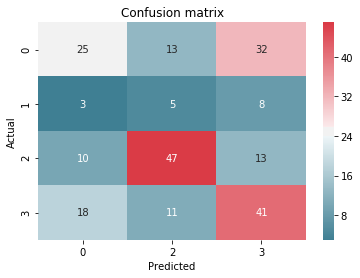

In [100]:
data = {'y_val': y_val, 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [101]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.36      0.40        70
           1       0.00      0.00      0.00        16
           2       0.62      0.67      0.64        70
           3       0.44      0.59      0.50        70

    accuracy                           0.50       226
   macro avg       0.38      0.40      0.39       226
weighted avg       0.46      0.50      0.48       226



**Overall, the performances of this baseline model are quite poor, especially for the covid class because of the imbalance issue. We will explore data augmentation and class weigthing to improve our results.**

---

# Appendix

In [93]:
# Computing the accuracy manually to check 
(df['y_val'] == df['y_pred']).sum() / len(df)

0.4469026548672566